### This notebook aims to train a VAE model


### (1). Collecting the training data (for 1q-case for example)

In [1]:
#====================some useful functions==========================

from QPT import QPT
from QPT import *
from numExp_qiskit import NumExp
from joblib import Parallel, delayed
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import itertools, random
from qutip import Qobj
from qutip.random_objects import rand_super_bcsz, rand_kraus_map, rand_unitary
from qiskit.quantum_info import random_unitary, Operator, average_gate_fidelity, Kraus, Chi, Choi
from scipy.linalg import sqrtm
import random
from os import listdir
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
from qutip.random_objects import rand_super_bcsz, rand_kraus_map, rand_unitary
from brokenaxes import brokenaxes

from functions import generate_valid_cptp_kraus_operators,get_chiF

### (1). Perparing the training data with qiskit simulator

In [2]:
# ======================================================
# ========= perpare the training data =================#
# ======================================================

# def get_chi_num(N,num_kraus,p_inco,p_coh):
#     '''
#     p_inco: coherent error strength (depolization channel);p_coh: coherent error (unitary uncertaintity)
#     get chi matrix for a given quantum channel, based on the qiskit simulator
#     return: the chi for identity process, std QPT, ideal QPT
#     '''

#     rdw = np.random.random(1)[0] # the weight coefficient
#     p_reset = p_inco * rdw
#     p_meas = p_inco*(1-rdw)
    
#     random_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)
#     # Define the Hilbert space dimension
#     qiskit_sim = NumExp()
#     Uid = np.identity(2 ** N)
#     measure_data_id = qiskit_sim.get_measurement(N, p_reset, p_meas,p_coh, [Uid])
    
#     qptid = QPT(N, measure_data_id, random_channel)
#     chi_id_pred = qptid.get_chi_LS_X(qptid.rho_in_idea, qptid.observables)
#     newdata = np.array([np.real(chi_id_pred),np.imag(chi_id_pred)])
#     return newdata#,chi_pred,chi_idea 

# N_train = 1000
# N = 2
# num_kraus = 1
# plist = np.linspace(0,0.2,10)

# ## Notes: time cost for the 1000 training data of the whole plist: 2hours(N=1),12hour(N=2) without parallel computing.
# Fcell_allp = []
# for p_tot in plist:
#     data_id_VAE = np.zeros(shape=(N_train,2,2**(2*N),2**(2*N)))
#     for i in range(N_train):#N_train
#         if i%100==0:
#             print(i)
#         quantum_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)
#         chi_id_pred = get_chi_num(N,num_kraus,p_tot)
#         newdata = np.array([np.real(chi_id_pred),np.imag(chi_id_pred)])
#         data_id_VAE[i]=newdata
#         Fcell_allp.append(data_id_VAE)
    
# # or using the parallel setups
# #Fcell_allp = Parallel(n_jobs=10, verbose=5)(delayed(get_chi_num)(N,num_kraus,p_tot) for i in range(N_train))
# #np.savez('./VAE/fig_'+str(N)+'q_1kraus_chi_new.npz',data_id_VAE=data_id_VAE,plist=plist)


### (2). Train a VAE model

In [2]:
from functions import EM_QPT
import torch
import torch.nn.functional as F
import random

N=1
exp=1
if N ==1:
    from VAE.model import *
    if exp==0:
        data_chi = np.load('chi_1q_1kraus_log_2d_selected.npz')#('./VAE/fig_1q_1kraus_chi.npz')
        Nshot = 10000
    else:
        data_chi = np.load('chi_1d_36h.npz') #fig_1q_1kraus_chi_exp: the 24x100
        #data_chi = np.load('./chi_cell_6points.npz')#np.load('./VAE/fig_1q_1kraus_chi_exp_test100.npz')
        Nshot = 10000
        qpt_avg_data = data_chi['qpt_avg_data']# qpt_avg_data_new
        gate_list = data_chi['gate_ideal']
        gate_num = len(gate_list)
        ideal_gate_list = gate_list
elif N==2:
    from VAE.model_2q import *
    if exp==0:
        data_chi = np.load('chi_2q_1kraus_log_2d_selected0_4.npz')
        Nshot = 10000
    else:
        data_chi = np.load('chi_id_cz_interleaved_QPT.npz')
        Nshot = 4096

else:
    print('wrong N')


def is_CPTP_chi_np(chi_matrix, N, tol=1e-5):
    """
    判断 NumPy Chi 矩阵是否是 CPTP
    """
    dim2 = chi_matrix.shape[0]
    dim = int(dim2 ** 0.5)

    pauli = [qeye(2), sigmax(), sigmay(), sigmaz()]
    pauli_basis = [tensor(*op) for op in product(pauli, repeat=N)]
    pauli_basis = [p.full() for p in pauli_basis]


    if not np.allclose(chi_matrix, chi_matrix.T.conj(), atol=tol):
        return False

    # 2. CP
    eigenvalues = np.linalg.eigvalsh(chi_matrix)
    # print('eigenvalues',eigenvalues)
    if np.any(eigenvalues < -tol):
        return False

    # 3. TP
    identity = np.eye(dim, dtype=np.complex64)
    trace_test = sum(chi_matrix[m, n] * pauli_basis[n].conj().T @ pauli_basis[m]
                     for m in range(dim2) for n in range(dim2))

    if not np.allclose(trace_test, identity, atol=tol * 100):
        print('trace perseving',np.allclose(trace_test, identity, atol=tol),trace_test)
        return False

    return True

def clean_cholesky(img):
    """
    清洗输入矩阵，得到用于 Cholesky 分解的矩阵 T

    Args:
        img (torch.Tensor): 形状为 (batch_size, hilbert_size, hilbert_size, 2)
                            的张量，表示神经网络的随机输出。
                            最后一个维度用于分离实部和虚部。

    Returns:
        T (torch.Tensor): 形状为 (N, hilbert_size, hilbert_size) 的张量，
                          表示 N 个用于 Cholesky 分解的矩阵（复数张量）。
    """
    # 分离实部和虚部
    real = img[:,0,:, :]
    imag = img[:,1,:, :]

    # 取虚部的对角线元素
    diag_all = torch.diagonal(imag, dim1=1, dim2=2)  # shape: (batch_size, hilbert_size)
    # 构造对角矩阵
    diags = torch.diag_embed(diag_all)

    # 将虚部对角线元素置零
    imag = imag - diags

    # 取下三角部分
    real = torch.tril(real)
    imag = torch.tril(imag)

    # 构造复数矩阵
    T = torch.complex(real, imag)
    return T

def density_matrix_from_T(tmatrix):
    """
    从 T 矩阵得到密度矩阵，并进行归一化

    Args:
        tmatrix (torch.Tensor): 形状为 (N, hilbert_size, hilbert_size)
                                 的张量，表示 N 个有效的 T 矩阵（复数张量）。

    Returns:
        rho (torch.Tensor): 形状为 (N, hilbert_size, hilbert_size) 的张量，
                            表示 N 个密度矩阵。
    """
    T = tmatrix
    # 计算共轭转置 T†
    T_dagger = T.transpose(-1, -2).conj()

    # 计算 T_dagger @ T
    proper_dm = torch.matmul(T_dagger, T)

    # 计算每个矩阵的迹
    traces = torch.einsum('bii->b', proper_dm)
    # 计算归一化因子 1/trace，并调整形状便于广播
    inv_traces = 1.0 / traces
    inv_traces = inv_traces.view(-1, 1, 1)

    # 归一化密度矩阵
    rho = proper_dm * inv_traces

    # rho = rho.view(rho.shape[0], rho.shape[1]*rho.shape[2])
    return rho

def reshape_expdata(data_I):
    exp_data_I =np.zeros(shape=(12,2)) 
    th = 0
    for i in range(4):
        for j in range(3):
            exp_data_I[th,:2]=data_I[:2,i,j]/np.sum(data_I[:2,i,j])
            th+=1
    return exp_data_I


def wasserstein_distance_1d(x, p, q):
    F_p = torch.cumsum(p, dim=0)
    F_q = torch.cumsum(q, dim=0)
    dx = x[1:] - x[:-1]
    distance = torch.sum(torch.abs(F_p[:-1] - F_q[:-1]) * dx)
    return distance

def cal_W1(recon_x, qpt_avg_data, gate_list):
    #print('recon_x',recon_x)
    DT_iden_list = []
    for da in recon_x:
        re_part = da[0]
        im_part = da[1]
        DT_iden_list.append(re_part + im_part * 1j)

    digital_twin = random.choice(DT_iden_list)
    Flist = [get_pdf_digital(qpt_avg_data, gate_list, digital_twin)]
    Flist = torch.cat(Flist).clamp(max=1 - 1e-8)

    log_vals = torch.log10(1 - Flist)
    bnum, rg = 50, [-5, 0]  # 缩小 bin 数以降低内存使用

    hist = torch.histc(log_vals, bins=bnum, min=rg[0], max=rg[1])
    pro1 = hist / (hist.sum() + 1e-8)

    delta_pro = torch.zeros_like(pro1)
    delta_pro[0] = 1

    F_weight = torch.linspace(0, 1, bnum, device=pro1.device)
    w = wasserstein_distance_1d(F_weight, pro1, delta_pro)
    print('w1 distance:', w.item(),'Flist',Flist )
    return w

def get_pdf_digital(qpt_avg_data, gate_list, digital_twin):
    gate_num = len(gate_list)
    F_cell_digital = []

    for jj in range(10):  # 减少循环次数
        measure_list = [reshape_expdata(qpt_avg_data[0, jj, :, i, :, :]) for i in range(gate_num)]
        for i in range(gate_num):
            measure_data_id = []
            idea_channel = [gate_list[i]]
            measure_data_gate = measure_list[i][:, :2]
            _, _, _, FF_EM_c = EM_QPT(N, idea_channel, measure_data_gate, measure_data_id, chi_digital=digital_twin)
            F_cell_digital.append(torch.tensor([FF_EM_c], dtype=torch.float32))
    
    return torch.cat(F_cell_digital)


def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # if epoch > 1000:
    #     #with torch.no_grad():  # 避免 W1 反向传播
    #     W1 = cal_W1(recon_x.detach().numpy(), qpt_avg_data, gate_list)
    #     loss = BCE + KL_div + W1
    #     print('Loss parts:',loss.item(), W1.item(), BCE.item(), KL_div.item())
    # else:
    loss = BCE + KL_div
    return loss

# 训练 VAE
def train_vae(model, train_loader, optimizer, epochs=10, device='cuda'):
    model.train()
    losslist=[]
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data,) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar )
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        losslist.append(train_loss)
        if epoch%20==0:
            print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.5f}")
    return  losslist
# 测试 VAE

def test_vae(model, test_loader, device='cuda'):
    z_space = []
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, in test_loader:
            #data = data.to(device)
            recon, mu, logvar = model(data)# mu is the latant vector
            #z = model.reparameterize(mu, logvar)
            z_space.append(mu.numpy())
            loss = loss_function(recon, data, mu, logvar)
            test_loss += loss.item()
    print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")
    return z_space
# 运行 VAE 训练和测试


### loading the training data

In [3]:

# if exp==0:
#     chi_cell = data_chi['chi_cell_p']#.reshape(1,1000,16,16)
#     print('data_chi.shape',np.shape(chi_cell))
#     plist = data_chi['plist']
#     print(np.shape(chi_cell))
#     new_chi_cell =[]
#     for i in range(len(chi_cell)):
#         new_chi_list = []
#         for j in range(len(chi_cell[0])):
#             chi = chi_cell[i,j,:,:]
#             realpart,imgpart  = np.real(chi),np.imag(chi)
#             # realpart[np.abs(realpart) < 10/4096] = 0 # the filter to reduce the small noise below statistic theshold
#             # imgpart[np.abs(imgpart) < 10/4096] = 0
#             new_chi_list.append( [np.real(chi),np.imag(chi)])
#         new_chi_cell.append(new_chi_list)
#     new_chi_cell = np.array(new_chi_cell)
#     print(np.shape(new_chi_cell))
# else:
#     chi_cell = data_chi['chi_cell_id']
#     # chi_optimal = np.load('chi_optimal.npz')
#     # chi_cell = chi_optimal['chi_optimized']
#     gate_list = data_chi['gate_ideal']
#     Fc_cell =  data_chi['F_cell']
#     new_chi_cell = []
#     for j in range(len(chi_cell)):
#         if np.log10(1-np.average(Fc_cell[j,2,-1]))<0:# and np.log10(1-np.average(Fc_cell[j,:,-1]))>-3.7:
#             chi = chi_cell[j,:,:]
#             realpart,imgpart  = np.real(chi),np.imag(chi)
#             realpart[np.abs(realpart) < 1/Nshot] = 0.0 # the filter to reduce the small noise below statistic theshold
#             imgpart[np.abs(imgpart) < 1/Nshot] = 0.0
#             new_chi_cell.append([np.real(chi),np.imag(chi)])
#     new_chi_cell = np.array(new_chi_cell)
#     print(np.shape(new_chi_cell))

def from_chi_to_NN(chi_cell):
    a,b,c,d =np.shape(chi_cell)
    new_chi_cell = []
    for th in range(a):
        for j in range(b):
            chi = chi_cell[th,j,:,:]
            realpart,imgpart  = np.real(chi),np.imag(chi)
            realpart[np.abs(realpart) < 1/Nshot] = 0.0 # the filter to reduce the small noise below statistic theshold
            imgpart[np.abs(imgpart) < 1/Nshot] = 0.0
            new_chi_cell.append([realpart,imgpart])
    new_chi_cell = np.array(new_chi_cell).reshape(a,b,2,c,d)
    return new_chi_cell

# CZ gate
# chi_cell = data_chi['chi_cell_p']
# plist = data_chi['plist']#

# one-q gate
chi_cell = data_chi['chi_cell_id']
a,b,c = np.shape(chi_cell)
chi_cell = np.reshape(chi_cell,newshape=(1,a,b,c))
print(np.shape(chi_cell))
#plist =['6points']
plist =['36h']

new_chi_cell = from_chi_to_NN(chi_cell)
print(np.shape(new_chi_cell))

(1, 2400, 4, 4)
(1, 2400, 2, 4, 4)


(400, 2, 4, 4)

p_tot= 36h
Epoch 1, Loss: 1.07521
Epoch 21, Loss: 0.05216
Epoch 41, Loss: 0.01100
Epoch 61, Loss: 0.00603
Epoch 81, Loss: 0.00433
Epoch 101, Loss: 0.00365
Epoch 121, Loss: 0.00335
Epoch 141, Loss: 0.00308
Epoch 161, Loss: 0.00288
Epoch 181, Loss: 0.00287
Epoch 201, Loss: 0.00274
Epoch 221, Loss: 0.00269
Epoch 241, Loss: 0.00269
Epoch 261, Loss: 0.00267
Epoch 281, Loss: 0.00263
Epoch 301, Loss: 0.00261
Epoch 321, Loss: 0.00261
Epoch 341, Loss: 0.00259
Epoch 361, Loss: 0.00255
Epoch 381, Loss: 0.00255
Test Loss: 0.0029


/var/folders/gt/wsynvnn526b468b8m4bq36g00000gn/T/ipykernel_86025/126814118.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


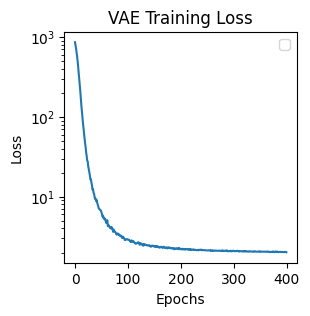

In [32]:
# Notes: the shape of training data: (trainnum,2,2**(2N),2**(2N))
# hyperparameters
#trainnum,batch_size,epochs,latent_dim = 1000,8,200,2 # two-qubit case

trainnum,batch_size,epochs,latent_dim = 800,32,400,2# single-qubit case
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
th = 0
p = plist[0]# choosing one of p to play with.
p_tot,num_kraus=p,1
print('p_tot=',p)
num_data1 = new_chi_cell[th]#[500:][th]#

indices = np.random.choice(len(num_data1), trainnum, replace=False)
data = num_data1[indices,:, :, :]
train_data = torch.from_numpy(data).float()#.view(-1, 7)

testnum = int(100) # testing data for evaluation
data_test =  data[:testnum,:, :, :]
test_data = torch.from_numpy(data_test).float()
# test_data = TensorDataset(data)
train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=testnum, shuffle=True)

model = VAE(latent_dim,input).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
losslist = train_vae(model, train_loader, optimizer, epochs, device)

z_space  = test_vae(model, test_loader, device)

plt.figure(figsize=(3,3))
plt.plot(losslist)
plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Loss")
plt.show()


<Figure size 640x480 with 0 Axes>

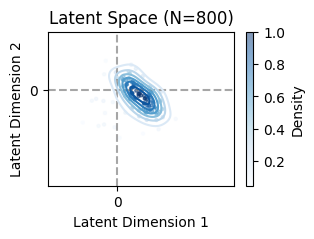

In [33]:
#=========model evaluation: the distrbution of latent space =======
plt.figure()
# #x = np.arange(len(z_space[0]))
if len(z_space[0][0]) > 0:
    z  = TSNE(n_components=2).fit_transform(z_space[0])
else:
    z =z_space[0]
x,y = [z[0] for z in z_space[0]], [z[1] for z in z_space[0]]# t-SNE 降维潜在空间
x,y = np.array(x),np.array(y)
xy = np.vstack([x, y])
density = gaussian_kde(xy)(xy)
density /=np.max(density)

# 创建密度等高线图
fig, ax = plt.subplots(figsize=(3, 2))
ax.set_title("Latent Space (N="+str(trainnum)+")")
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.axhline(0, color='gray', linestyle='--', alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', alpha=0.7)
# 绘制散点并用颜色表示密度
sc = ax.scatter(x, y, c=density, cmap="Blues", s=5, alpha=0.5)
# 生成等高线
xmin, xmax =  x.min() *2, x.max() *2
ymin, ymax =  y.min() *2, y.max()*2
X, Y = np.meshgrid(np.linspace(xmin, xmax, 1000), np.linspace(ymin, ymax, 1000))
positions = np.vstack([X.ravel(), Y.ravel()])
Z = gaussian_kde(xy)(positions).reshape(X.shape)
Z /= np.max(Z)
ax.contour(X, Y, Z, levels=6, cmap="Blues")
# 添加颜色条
plt.xticks([0])
plt.yticks([0])
plt.colorbar(sc, label="Density")
plt.show()


In [34]:
#=========model evaluation: is the output of trained model CPTP ?=======
torch.save(model.state_dict(), './VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth')
print('saved model:','./VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth')
model = VAE(latent_dim,input)
model.load_state_dict(torch.load('./VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth',weights_only=False))
model.eval()
with torch.no_grad():
    z = torch.randn(400, latent_dim)#.to(device)  # 随机采样 latent vector
    sample0 = model.decode(z)
    sample1 = clean_cholesky(sample0.reshape(400,2,2**(2*N),2**(2*N)))
    sample2 = density_matrix_from_T(sample1)
    sample2_numpy = sample2.cpu().numpy()
    print('is it Hermitian?',np.allclose(sample2_numpy[0],sample2_numpy[0].T.conj(),atol=1e-5))
    print('is it CPTP?',is_CPTP_chi_np(sample2_numpy[0],N ))
    # np.allclose(sample2_numpy[0],sample2_numpy[0].T.conj(),atol=1e-5) # 判断Hermitial
    sample = sample0.cpu().numpy()
print("Generated Sample Shape:", np.shape(sample))


saved model: ./VAE/save_model/1q/model_weights800p=36h_exp.pth
is it Hermitian? True
is it CPTP? True
Generated Sample Shape: (400, 2, 4, 4)


In [130]:
'./VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth'

'./VAE/save_model/1q/model_weights10p=36h_exp.pth'

In [136]:
np.shape(sample )

(400, 2, 4, 4)

<Figure size 640x480 with 0 Axes>

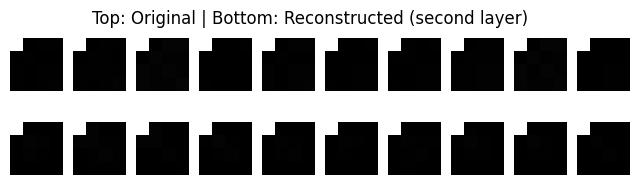

<Figure size 640x480 with 0 Axes>

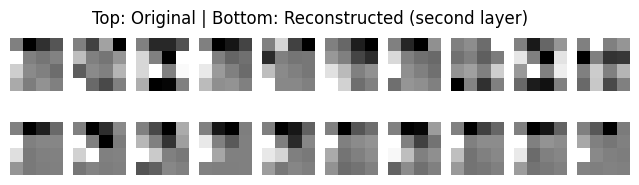

In [35]:
#=========model evaluation: the comparsion between the training data and its digital twin ?=======
images = sample #num_data1[:100]
plt.figure()
fig, axes = plt.subplots(2, 10, figsize=(8, 2))
for i in range(10):
    recons_data = images[i][0].reshape(2**(2*N),2**(2*N))#sample[i]
    #recons_data = reconstruct_images(recons_data)
    axes[0, i].imshow(num_data1[i, 0], cmap="gray")  # 原始输入
    axes[1, i].imshow(recons_data, cmap="gray")  # 生成输出
    axes[0, i].axis("off")
    axes[1, i].axis("off")
plt.suptitle("Top: Original | Bottom: Reconstructed (second layer)")
plt.show()

plt.figure()
fig, axes = plt.subplots(2, 10, figsize=(8, 2))
for i in range(10):
    #recons_data = sample[i]
    recons_data = images[i][1].reshape(2**(2*N),2**(2*N))
    #recons_data = reconstruct_images(recons_data)
    axes[0, i].imshow(num_data1[i, 1], cmap="gray")  # 原始输入
    axes[1, i].imshow(recons_data, cmap="gray")  # 生成输出
    axes[0, i].axis("off")
    axes[1, i].axis("off")
plt.suptitle("Top: Original | Bottom: Reconstructed (second layer)")
plt.show()

In [10]:
# '''
# #========================================================================
# #================== CZ gate ML-QPT====================================
# #========================================================================
# #========================================================================
# '''


# from functions import EM_id_chi
# import pandas as pd
# #Uid = np.identity(2 ** N)  #
# data_loc1 = './exp_data/CZdata/interleaved_QPT/'#'./QPT_data_25/' #'./raw_interleaved_QPT_no_motzoi/'
# data_loc2 ='./exp_data/CZdata/raw_interleaved_QPT/'
# data_loc3 ='./exp_data/CZdata/raw_interleaved_QPT_no_motzoi/'
# loclist = [data_loc1,data_loc2,data_loc3]
# #loading the experimental data from Anuj for the CZ gate
# Ucz = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])
# F_cell=[]
# chi_identity_cell = []
# for data_loc in [loclist[0]]:
#     # # ==================== the trained model ==========================
#     model_name =  './VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth'
#     print('loading:', model_name)
#     # ==================== the trained model ==========================
#     model = VAE(latent_dim, input)
#     model.load_state_dict(torch.load(model_name, weights_only=False))  #
#     model.eval()
#     strlist =  np.sort(listdir(data_loc))
#     Flist,chi_list=[],[]
#     for th in range(int(len(strlist)/2)-1):
#         th = th*2+1
#         #======== realistic idle experiments =====
#         strt0 = strlist[2+th]
#         print(th,'idenitiy file:',strt0) # should be identity
#         WS0 = pd.read_excel(data_loc+strt0)#('cz.xlsx')
#         WS_np0 = np.array(WS0)
#         # ==============================================================

#         with torch.no_grad():
#             z = torch.randn(10, latent_dim)  # 随机采样 latent vector
#             sample = model.decode(z).cpu().numpy()
#         #sample = [reconstruct_images(sam) for sam in sample]
#         data_digital = sample

#         DT_iden_list = []
#         for da in data_digital:
#             re_part = da[0]#.reshape(4, 4)
#             im_part = da[1]#.reshape(4, 4)
#             DT_iden_list.append(re_part + im_part * 1j)
#         digital_twin = random.choice(DT_iden_list)
        
#         # # ==============================================================

#         strt  = strlist[th+1]
#         print('gate file:',strt)# should be the gate
#         WS = pd.read_excel(data_loc+strt)
#         WS_np = np.array(WS)
#         measure_data_gate,measure_data_id = WS_np[:144,2:],WS_np0[:144,2:]

#         idea_channel =[Ucz]#[Qobj(Ucz,dims=[[2] * N] * N if N > 1 else [[2], [2]])]
#         # ff = 0
#         # for digital_twin in DT_iden_list: # averaged out with digital twin
#         #     _,_,_,FF_EM_c_digital = EM_QPT(N,idea_channel,measure_data_gate,measure_data_id,chi_digital=digital_twin,chi_fid=False,notes='cz')
#         #     ff+=FF_EM_c_digital
#         # FF_EM_c_digital_ave = ff/len(DT_iden_list)

#         F_cell_para = Parallel(n_jobs=10, verbose=5)(delayed(EM_QPT)(N,idea_channel,measure_data_gate,measure_data_id,chi_digital=dw,chi_fid=False,notes='cz') for dw in DT_iden_list)
#         FF_EM_c_digital_ave = np.nanmean([F[-1] for F in F_cell_para])
#         #FF_no_EM,_,_,FF_EM_c = EM_QPT(N,idea_channel,measure_data_gate,measure_data_id,chi_fid=False)
#         #chi_id_pred, chi_pred, chi_idea, chi_EM, chi_EM1, chi_EM2= get_result_exp(N,Ucz,measure_data_gate,measure_data_id)
        
#         # FF_noEM,FF_EM_a,FF_EM_b,FF_EM_c= EM_QPT(N,idea_channel,measure_data_gate,measure_data_id,notes='cz')
#         #=====enhanced QPT======
#         #_, _, _, _, _, chi_EM2_digital = get_result_exp(N,Ucz,measure_data_gate,measure_data_id,DT_id)
#         print('Fidelity:', FF_EM_c_digital_ave)
#         Flist.append([FF_EM_c_digital_ave])
    
#     chi_identity_cell.append(chi_list)
#     F_cell.append(Flist)

# #np.savez('fig_id_CZ_exp_100_10Mar_only_onechi.npz',chi_list=chi_identity_list)

In [11]:
#np.savez('F_digital_cz2.npz',F_list = Flist)

In [ ]:
'''
#========================================================================
#================== single-qubit gate ML-QPT============================= 
#========================================================================
#========================================================================
'''
from functions import EM_QPT

qpt_avg_data =data_chi['qpt_avg_data']

# data100 = np.load('data_100test_22Apr.npz')
# qpt_avg_data =data100['qpt_avg_data']# qpt_avg_data_new

a,b,c,d,e,f = np.shape(qpt_avg_data)
print(a,b,c,d,e,f)
## measurement 
NDT = 20
gate_inex = -1


qpt_avg_data_flatt = np.reshape(qpt_avg_data,newshape=(a*b,c,d,e,f))
tot_iden_list = np.array([reshape_expdata(qpt_avg_data_flatt[kk,:,0,:,:]) for kk in range(a*b)])[:trainnum]
print(np.shape(tot_iden_list))
#tot_iden_list = [reshape_expdata(qpt_avg_data[kk,jj,:,0,:,:]) for i in range(gate_num)]
#tot_X_list = newqpt_avg_data[:,:,gate_inex,:,:]


# gate_num = len(gate_list)
ideal_gate_list = gate_list


# data_chi = np.load('./VAE/fig_1q_1kraus_chi_exp_test100.npz')
# qpt_avg_data =data_chi['qpt_avg_data']# qpt_avg_data_new
# gate_list = data_chi['gate_ideal']
# gate_num = len(gate_list)

model_name =  './VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth'
print('loading:', model_name)
# ==================== the trained model ==========================
model = VAE(latent_dim, input)
model.load_state_dict(torch.load(model_name, weights_only=False))  #
model.eval()
chi_optimized = []
F_cell_digital = []

for kk in range(1):#len(qpt_avg_data)
    kk = 10
    print(kk)
    F_list_digital = []
    for jj in range(len(qpt_avg_data[0])):#
        measure_list =[reshape_expdata(qpt_avg_data[kk,jj,:,i,:,:]) for i in range(gate_num)]
        with torch.no_grad():
            z = torch.randn(NDT, latent_dim)  # 随机采样 latent vector
            sample = model.decode(z).cpu().numpy()
        #sample = [reconstruct_images(sam) for sam in sample]
        data_digital = sample

        DT_iden_list = []
        for da in data_digital:
            re_part = da[0]#.reshape(4, 4)
            im_part = da[1]#.reshape(4, 4)
            DT_iden_list.append(re_part + im_part * 1j)
        digital_twin = random.choice(DT_iden_list)

        tot_iden_list = [qpt_avg_data_flatt[np.random.choice(100, 1)[0],:,0,:,:] for i in range(NDT)]

        given_gate = measure_list[gate_inex][:,:2]# reshape_expdata(qpt_avg_data[0,1,:,gate_inex,:,:])#measure_list[gate_inex]#
        measure_data_id = measure_list[0]
        idea_channel = [ideal_gate_list[gate_inex]]
        measure_data_gate = given_gate[:,:2] #measure_list[gate_inex][:,:2]
        FF_no_EM,_,_,FF_EM_c = EM_QPT(N,idea_channel,measure_data_gate,measure_data_id,chi_digital=[],chi_fid=False)

        # F_cell_para_all = Parallel(n_jobs=10, verbose=5)(delayed(EM_QPT)(N,idea_channel,measure_data_gate,reshape_expdata(gate_id),chi_digital=[],chi_fid=False) for gate_id in tot_iden_list)
        # F_cell__all_ave = np.average([F[-1] for F in F_cell_para_all])

        F_cell_para = Parallel(n_jobs=10, verbose=5)(delayed(EM_QPT)(N,idea_channel,measure_data_gate,measure_data_id,chi_digital=dw,chi_fid=False) for dw in DT_iden_list)
        F_dig = np.average([F[-1] for F in F_cell_para])

        F_list_digital.append([FF_no_EM,FF_EM_c, F_dig])#,FF_EM_c_digital_ave
    F_cell_digital.append(F_list_digital)
print(np.shape(F_cell_digital))

24 100 3 4 4 3
(800, 12, 2)
loading: ./VAE/save_model/1q/model_weights800p=36h_exp.pth
10


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out

(1, 100, 3)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:    0.1s finished


In [49]:
np.savez('36_h_'+str(trainnum)+'train.npz',F_cell_digital=F_cell_digital)
#np.shape()
 

(1, 100, 3)
[0.24951365]
[0.45393502]
[0.56048002]


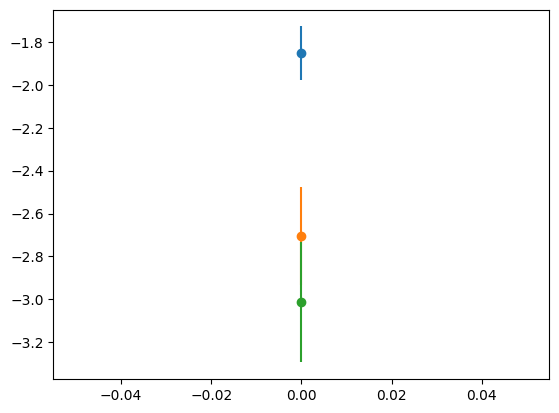

In [48]:
F_cell_digital = np.array(F_cell_digital)
F_cell_digital1 = np.log10(1-F_cell_digital)#1-F_cell_digital#x,y
x = np.linspace(0,len(F_cell_digital1),len(F_cell_digital1))
print(np.shape(F_cell_digital1))
for th in range(3):
    y,ystd = np.array([np.average(F[:,th]) for F in F_cell_digital1]),np.array([np.std(F[:,th]) for F in F_cell_digital1])
    plt.errorbar(x,y,ystd/2)
    plt.scatter(x,y)
    print(ystd)
# plt.yscale('log')
#plt.hlines(y=np.log10(1-0.9997),xmin=-0.1,xmax=6.1,lw=0.6,linestyles='--',colors='k',zorder=1,label=r'$F_{\text{rb}}\approx 99.97\%$')
#plt.ylim([-4,-1])


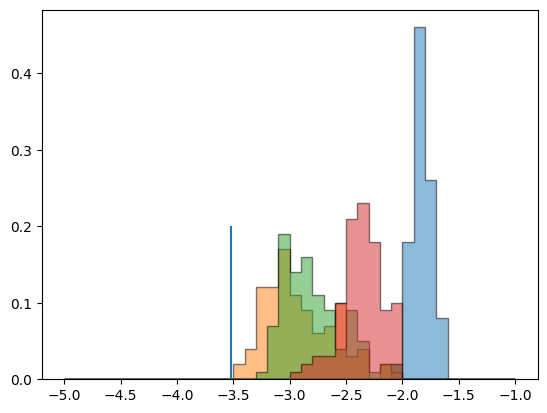

In [22]:
FF = np.array(F_cell_digital[0])
for i in range(4):
    ff0 = FF[:,i]
    F0,F1 = ff0,ff0
    F0,F1 = np.log10(1-np.array(F0)),np.log10(1-np.array(F1))
    bn = 40
    rg = [-5, -1]
    counts, bins = np.histogram(np.array(F0), bins=bn, range=rg)
    kwargs = dict(histtype='stepfilled', alpha=0.5, edgecolor='black')  ##3b8fc2,color='#795548'
    plt.hist(bins[:-1], bins, weights=counts / np.sum(counts), label=r'$std-QPT$', **kwargs)
F_rb = np.log10(1-0.9997)
plt.vlines(x=F_rb, ymax=0.2,ymin=0)

 

In [ ]:
'''
#========================================================================
#================== single-qubit gate ML-QPT============================= 
#========================================================================
#========================================================================
'''
from functions import EM_QPT
qpt_avg_data =data_chi['qpt_avg_data']
model_name =  './VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'_exp.pth'
print('loading:', model_name)
# ==================== the trained model ==========================
model = VAE(latent_dim, input)
model.load_state_dict(torch.load(model_name, weights_only=False))  #
model.eval()
chi_optimized = []
F_cell_digital = []

a,b,c,d,e,f = np.shape(qpt_avg_data)
print(a,b,c,d,e,f)
## measurement 
qpt_avg_data_flatt = np.reshape(qpt_avg_data,newshape=(a*b,c,d,e,f))
newqpt_avg_data = qpt_avg_data_flatt[:100]
tot_iden_list = newqpt_avg_data[:,:,0,:,:]
tot_X_list = newqpt_avg_data[:,:,-1,:,:]
Fcell = []
for gate_x in tot_X_list[:100]:
    ## digital twin
    with torch.no_grad():
        z = torch.randn(100, latent_dim)  # 随机采样 latent vector
        sample = model.decode(z).cpu().numpy()
    #sample = [reconstruct_images(sam) for sam in sample]
    data_digital = sample

    DT_iden_list = []
    for da in data_digital:
        re_part = da[0]#.reshape(4, 4)
        im_part = da[1]#.reshape(4, 4)
        DT_iden_list.append(re_part + im_part * 1j)
    digital_twin = random.choice(DT_iden_list)

    given_gate = reshape_expdata(gate_x) #reshape_expdata(qpt_avg_data[0,1,:,gate_inex,:,:])#measure_list[gate_inex]#
    idea_channel = [ideal_gate_list[gate_inex]]
    measure_data_gate = given_gate[:,:2]#measure_list[gate_inex][:,:2]
    
    F_cell_para = Parallel(n_jobs=10, verbose=5)(delayed(EM_QPT)(N,idea_channel,measure_data_gate,measure_data_id,chi_digital=dw,chi_fid=False) for dw in DT_iden_list)
    F_cell_para0 = [F[-1] for F in F_cell_para]
    #FF_EM_c_digital_ave = np.nanmean([F[-1] for F in F_cell_para])
    
    F_cell_para_real = Parallel(n_jobs=10, verbose=5)(delayed(EM_QPT)(N,idea_channel,measure_data_gate,reshape_expdata(gate_id),chi_digital=[],chi_fid=False) for gate_id in tot_iden_list)
    F_cell_para1 = [F[-1] for F in F_cell_para_real]
    #FF_EM_c_real_ave = np.nanmean([F[-1] for F in F_cell_para])
    Fcell.append([F_cell_para0,F_cell_para1])


loading: ./VAE/save_model/1q/model_weights1000p=100test_exp.pth
1 100 3 4 4 3


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_

In [ ]:
np.shape(Fcell)

(100, 2, 100)

In [ ]:
#np.savez('F_cell_forW1.npz',Fcell=Fcell)

# data = np.load('F_cell_forW1.npz')
# Fcell_100W1 = data['Fcell']
# Fcell_100EM = F_cell_digital
# np.savez('F_cell_W1_100.npz',Fcell_100W1=Fcell_100W1,Fcell_100EM=Fcell_100EM)

In [ ]:
def wasserstein_distance_1d(logiFlist,rg,bn):
    """
    Compute the 1-Wasserstein distance (Earth Mover's Distance) between two discrete probability
    distributions on a one-dimensional, sorted support.

    Parameters:
    -----------
    x : array-like
        Sorted support points (in increasing order).
    p : array-like
        Probabilities for the first distribution (must sum to 1).
    q : array-like
        Probabilities for the second distribution (must sum to 1).

    Returns:
    --------
    float
        The 1-Wasserstein distance.
    """
    Flist = logiFlist# np.log10(1-Flist)
    xlist = np.linspace(rg[0],rg[1],bn)
    counts, bins = np.histogram(np.array(Flist), bins=bn, range=rg)
    pro_list = counts/np.sum(counts)
    pro_delt0 = np.zeros(bn);pro_delt0[0]=1

    #print(pro_list,pro_delt0)
    x = np.asarray(xlist)
    p = np.asarray(pro_list)
    q = np.asarray(pro_delt0)

    # Compute the cumulative distribution functions
    F_p = np.cumsum(p)
    F_q = np.cumsum(q)

    # Compute differences between successive support points
    dx = np.diff(x)

    # The 1-Wasserstein distance is given by summing the absolute differences
    # between the CDFs over the intervals.
    distance = np.sum(np.abs(F_p[:-1] - F_q[:-1]) * dx)
    return distance

bn = 1000
rg = [-6, 0]

#np.shape(Fcell)
W1list=[]
for f in Fcell:
    Flist0,Flist1 = np.log10(1-np.array(f[0])),np.log10(1-np.array(f[1]))
    w10 =  wasserstein_distance_1d(Flist0,rg,bn)/6
    w11 =  wasserstein_distance_1d(Flist1,rg,bn)/6
    W1list.append([w10,w11])
print(W1list)

[[0.4430130130130132, 0.4803103103103105], [0.4822222222222224, 0.5230830830830832], [0.44981981981982, 0.4836836836836838], [0.45257257257257266, 0.48537537537537556], [0.4236336336336339, 0.46215215215215233], [0.5401501501501503, 0.5460160160160162], [0.4761661661661663, 0.48848848848848864], [0.5571271271271273, 0.6035235235235237], [0.4766566566566568, 0.4871371371371373], [0.506826826826827, 0.5118418418418419], [0.5862862862862864, 0.5799299299299301], [0.5552252252252253, 0.5943443443443445], [0.6051151151151153, 0.6274874874874876], [0.6156056056056057, 0.6474774774774776], [0.6040940940940943, 0.6240840840840842], [0.5631531531531534, 0.5821821821821823], [0.5522822822822825, 0.5621021021021022], [0.5333233233233234, 0.5563263263263265], [0.530770770770771, 0.576716716716717], [0.5789089089089091, 0.5922922922922925], [0.6175775775775777, 0.6543943943943944], [0.6220920920920923, 0.6373973973973975], [0.5469169169169171, 0.5874874874874877], [0.5872372372372374, 0.61083083083

In [ ]:
W1listnew[:,0]

array([0.49268868, 0.73194061, 0.48540242, 0.49172339, 0.60938449,
       1.23547541, 0.83401457, 1.03804196, 0.99010249, 1.22714033,
       1.11827505, 1.13762256, 0.95736937, 0.80371678, 0.71376285,
       1.0957283 , 1.40429466, 1.36067315, 1.36791992, 1.17135762,
       0.62840183, 0.64433912, 1.35851275, 1.03505494, 1.41693004,
       1.20408317, 1.11655017, 1.06717003, 1.0842097 , 0.55558757,
       0.89996233, 0.83028635, 1.1726433 , 0.92429369, 1.03923458,
       0.79860333, 0.69615158, 0.85330079, 1.20838026, 0.80639563,
       0.60997172, 1.26848656, 1.30918424, 0.97466725, 1.27003224,
       0.78323112, 0.91428878, 0.96258962, 0.76634699, 1.10136315,
       0.90020333, 0.9115208 , 1.13138537, 0.75075915, 1.04760122,
       1.16294668, 1.0488331 , 1.0924551 , 0.87934152, 1.12833021,
       0.73522667, 0.68228077, 0.86261567, 0.85782395, 0.8073932 ,
       0.85074915, 0.63561804, 0.92038919, 0.75848953, 1.26128388,
       1.11362843, 0.80485868, 0.97634755, 0.93969127, 0.74468

(100, 2)


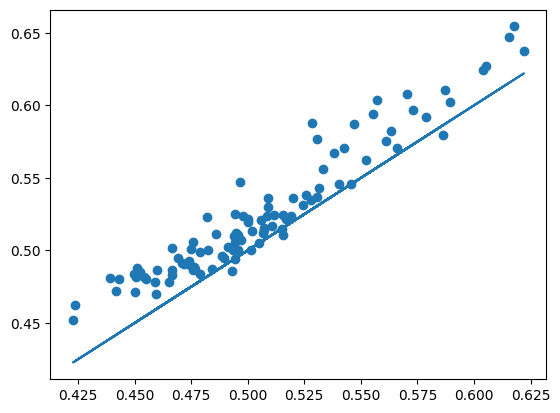

In [ ]:
W1listnew = np.array(W1list)
# plt.plot(W1listnew[:,0])
# plt.plot(W1listnew[:,1])
print(np.shape(W1listnew))
plt.scatter(W1listnew[:,0],W1listnew[:,1])
plt.plot(W1listnew[:,0],W1listnew[:,0])
# plt.ylim([0,3])
# plt.xlim([0,3])

In [ ]:
F_cell

[[[0.9967380756265019],
  [0.9859605086460308],
  [0.9987661909044677],
  [0.9990438255640358],
  [0.9929900802113586],
  [0.9895687333715314],
  [0.9989999382328285],
  [0.9960203311975739],
  [0.9953459198291712],
  [0.9909495525505584],
  [0.9990666096395324],
  [0.9991061660700102],
  [0.9884364114900899],
  [0.9963594566678978],
  [0.9991821622600421],
  [0.9930545528881423],
  [0.9931166787379763],
  [0.9923794087317876],
  [0.9987571916804889],
  [0.9904808003530163],
  [0.9948851555725691],
  [0.9992746031195118],
  [0.9957140254996102],
  [0.9942361289968742],
  [0.9979384320901057],
  [0.987597425438862],
  [0.9984395824205337],
  [0.9944722478118816],
  [0.9986748714490336],
  [0.9974881374756374],
  [0.9969917192946445],
  [0.9919049935049407],
  [0.9962627837528724],
  [0.9988015433195774],
  [0.9977121590803512],
  [0.9974219539220417],
  [0.9989731632314172],
  [0.9988760097898413],
  [0.9940392277071878],
  [0.9847846260749489],
  [0.9965259286574449],
  [0.996584104422

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01010101, 0.01010101,
        0.01010101, 0.01010101, 0.01010101, 0.03030303, 0.02020202,
        0.02020202, 0.03030303, 0.04040404, 0.02020202, 0.        ,
        0.01010101, 0.03030303, 0.01010101, 0.01010101, 0.        ,
        0.01010101, 0.        , 0.05050505, 0.03030303, 0.03030303,
        0.03030303, 0.01010101, 0.05050505, 0.01010101, 0.02020202,
        0.05050505, 0.06060606, 0.03030303, 0.03030303, 0.02020202,
        0.03030303, 0.03030303, 0.02020202, 0.04040404, 0.03030303,
        0.06060606, 0.01010101, 0.01010101, 0.02020202, 0.        ,
        0.        , 0.01010101, 0.01010101, 0.01

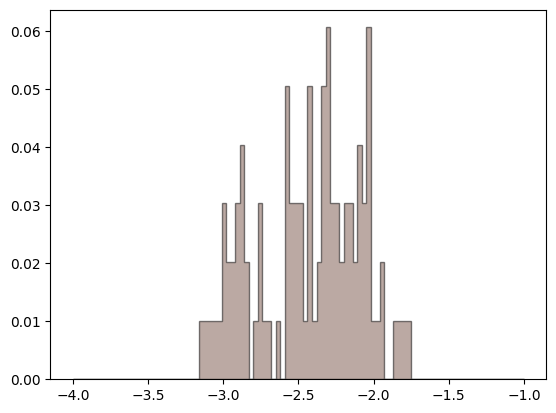

In [ ]:
ff0 = F_cell
F0,F1 = ff0,ff0
F0,F1 = np.log10(1-np.array(F0)),np.log10(1-np.array(F1))
bn = 100
rg = [-4, -1]
counts, bins = np.histogram(np.array(F0), bins=bn, range=rg)
kwargs = dict(histtype='stepfilled', alpha=0.5, edgecolor='black',color='#795548')  ##3b8fc2
plt.hist(bins[:-1], bins, weights=counts / np.sum(counts), label=r'$std-QPT$', **kwargs)
#plt.text(-4.8, 0.35,'(c)',ha="center", va="center", color="k",fontsize=FS+2)#fontweight='semibold',

# counts, bins = np.histogram(np.array(F1), bins=bn, range=rg)
# kwargs = dict(histtype='stepfilled', alpha=0.5, edgecolor='black',color='#3b8fc2')  ##3b8fc2
# plt.hist(bins[:-1], bins, weights=counts / np.sum(counts), label=r'$EM-QPT$', **kwargs)

In [ ]:
 
F = np.array(F_cell_digital)[100:,:]
print(np.shape(F))
gate_ind = 3
FS = 10
F0 = [np.average(np.log10(1-F[i ,0])) for i in range(len(F))]
F1 = [np.average(np.log10(1-F[i ,1])) for i in range(len(F))]
F2 = [np.average(np.log10(1-F[i ,2])) for i in range(len(F))]
plt.figure(figsize=(2,1.8))
bn = 100
rg = [-5, 0]
counts, bins = np.histogram(np.array(F0), bins=bn, range=rg)
kwargs = dict(histtype='stepfilled', alpha=0.5, edgecolor='black',color='#795548')  ##3b8fc2
plt.hist(bins[:-1], bins, weights=counts / np.sum(counts), label=r'$std-QPT$', **kwargs)
#plt.text(-4.8, 0.35,'(c)',ha="center", va="center", color="k",fontsize=FS+2)#fontweight='semibold',

counts, bins = np.histogram(np.array(F1), bins=bn, range=rg)
kwargs = dict(histtype='stepfilled', alpha=0.5, edgecolor='black',color='#3b8fc2')  ##3b8fc2
plt.hist(bins[:-1], bins, weights=counts / np.sum(counts), label=r'$EM-QPT$', **kwargs)

counts, bins = np.histogram(np.array(F2), bins=bn, range=rg)
kwargs = dict(histtype='stepfilled', alpha=0.5, edgecolor='black',color='orange')  ##3b8fc2
plt.hist(bins[:-1], bins, weights=counts / np.sum(counts), label=r'$ML-QPT$', **kwargs)

#plt.text(-4.8, 0.35,'(c)',ha="center", va="center", color="k",fontsize=FS+2)#fontweight='semibold',
#plt.vlines(x=infrb_ave,ymin=0,ymax=0.3,linestyles='--',colors='k',lw=0.5,label=r'$\overline{F}_{\text{rb}}$')
plt.xlabel(r'$\log_{10}(1-F_{\text{gate}})$', fontsize=FS)
plt.ylabel('probability', fontsize=FS)
plt.ylim([0.,0.5])
#plt.xlim([-5.,0])
#plt.xticks([-5,-4,-3,-2,-1,0])#,[' ',' ',' ',' ',' ',' ',' ']
plt.legend(fontsize=7,loc='upper right', frameon=True,ncol=1)
# plt.yticks([0,0.1,0.2,0.3])

plt.figure()
F_target = np.ones_like(F0)
F_target =  F_target*((rg[0]))*0.8 
for f in [F_target,F0,F1,F2]:
    counts, bins = np.histogram(np.array(f), bins=bn, range=rg)
    x = bins[:-1]
    y = counts / np.sum(counts)
    plt.plot(x,np.cumsum(y))


 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
F_target

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0.])

In [ ]:


def get_W1(Flist):
    Flist = np.log10(1-Flist)
    
    bn = 10**5;rg = [-5,0]
    xlist = np.linspace(rg[0],rg[1],bn)
    counts, bins = np.histogram(np.array(Flist), bins=bn, range=rg)
    pro_list = counts/np.sum(counts)
    pro_delt0 = np.zeros(bn);pro_delt0[0]=1
    w_1 = np.mean(np.abs(pro_list - xlist[0]))
    return w_1

Flist = F[:,2]
wq = get_W1(Flist)
    

In [ ]:
wq

5.00001

In [ ]:
wasserstein_distance_1d(F_target,rg,bn)

[0. 0. 0. ... 0. 0. 1.] [1. 0. 0. ... 0. 0. 0.]


5.0

In [ ]:
F[:,1]

array([0.99939177, 0.99948977, 0.99942599, 0.99964087, 0.99955081,
       0.99959774, 0.99942606, 0.99940594, 0.99855715, 0.99797694,
       0.99733033, 0.99896531, 0.99824444, 0.99936684, 0.99886636,
       0.99505943, 0.99943992, 0.99732042, 0.99856585, 0.99561894,
       0.99701155, 0.99933453, 0.99930838, 0.99924356, 0.99941057,
       0.99931942, 0.99927552, 0.99944945, 0.99950037, 0.99934283,
       0.99937911, 0.99922829, 0.99946973, 0.99906365, 0.99914545,
       0.99913071, 0.9994489 , 0.99875427, 0.99942256, 0.9991921 ,
       0.99850586, 0.9991339 , 0.99953024, 0.99938488, 0.99773721,
       0.99924013, 0.99621307, 0.99950686, 0.99918049, 0.99952797,
       0.9988778 , 0.99938747, 0.99565071, 0.99896935, 0.99926311,
       0.9993734 , 0.99933457, 0.99907354, 0.99951384, 0.9988307 ,
       0.99933774, 0.99932198, 0.99942093, 0.99946298, 0.99912371,
       0.99925075, 0.99676845, 0.99952394, 0.99931084, 0.99874682,
       0.99935484, 0.99950951, 0.99921454, 0.99932658, 0.99937

In [ ]:
# np.shape(chi_optimized)
# np.savez('chi_optimal.npz',chi_optimized=np.array(chi_optimized))
 

In [ ]:
# Flist_p = np.array(Flist_p)
# # for i in range(len(plist)):
# #     plt.scatter(i,np.log10(1-np.average(Flist_p[i,:,0])),color='b')
# #     plt.scatter(i,np.log10(1-np.average(Flist_p[i,:,1])),color='r')
# #     plt.scatter(i,np.log10(1-np.average(Flist_p[i,:,2])),color='k')
# # plt.ylim([-4.5,0.2])
# plist =plist[:4] 
# a,b = int(len(plist )),len(plist)
# F_cell_p = np.array(Flist_p)
# F_cell_p1 = np.array(np.log10(1-F_cell_p) )

# F_cell_ML= np.array([np.nanmean(F_cell_p1[i,:,0]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# F_cell_ML_std = np.array([np.std(F_cell_p1[i,:,0]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# xx,yy,ystd = plist,F_cell_ML,F_cell_ML_std
# plt.errorbar(xx,y=yy,yerr=ystd, ms=2,elinewidth=0.5)

# F_cell_ML= np.array([np.nanmean(F_cell_p1[i,:,1]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# F_cell_ML_std = np.array([np.std(F_cell_p1[i,:,1]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# xx,yy,ystd = plist,F_cell_ML,F_cell_ML_std
# plt.errorbar(xx,y=yy,yerr=ystd, ms=2,elinewidth=0.5)

# F_cell_ML= np.array([np.nanmean(F_cell_p1[i,:,2]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# F_cell_ML_std = np.array([np.std(F_cell_p1[i,:,2]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# xx,yy,ystd = plist,F_cell_ML,F_cell_ML_std
# plt.errorbar(xx,y=yy,yerr=ystd, ms=2,elinewidth=0.5)

# plt.xscale('log')

In [ ]:
# Flist_p = np.array(F_cell_digital)
# print(np.shape(Flist_p))
# # for i in range(len(plist)):
# #     plt.scatter(i,np.log10(1-np.average(Flist_p[i,:,0])),color='b')
# #     plt.scatter(i,np.log10(1-np.average(Flist_p[i,:,1])),color='r')
# #     plt.scatter(i,np.log10(1-np.average(Flist_p[i,:,2])),color='k')
# # plt.ylim([-4.5,0.2])
# plist =plist[:4] 
# a,b = int(len(plist )),len(plist)
# F_cell_p = np.array(Flist_p)
# F_cell_p1 = np.array(np.log10(1-F_cell_p) )

# F_cell_ML= np.array([np.nanmean(F_cell_p1[i,:,0]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# F_cell_ML_std = np.array([np.std(F_cell_p1[i,:,0]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# xx,yy,ystd = plist,F_cell_ML,F_cell_ML_std
# plt.errorbar(xx,y=yy,yerr=ystd, ms=2,elinewidth=0.5)

# F_cell_ML= np.array([np.nanmean(F_cell_p1[i,:,1]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# F_cell_ML_std = np.array([np.std(F_cell_p1[i,:,1]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# xx,yy,ystd = plist,F_cell_ML,F_cell_ML_std
# plt.errorbar(xx,y=yy,yerr=ystd, ms=2,elinewidth=0.5)

# F_cell_ML= np.array([np.nanmean(F_cell_p1[i,:,2]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# F_cell_ML_std = np.array([np.std(F_cell_p1[i,:,2]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# xx,yy,ystd = plist,F_cell_ML,F_cell_ML_std
# plt.errorbar(xx,y=yy,yerr=ystd, ms=2,elinewidth=0.5)

# plt.xscale('log')

### Numerical simulation on EM-QPT for the figure1

In [ ]:
# #========================================================================
# #=========model evaluation: (numerical simulation) comparing the EM-QTP and ML-QPT =======
# #========================================================================
# from functions import get_idea_chi_matrix,EM_QPT


# Flist,Flist_p = [],[]
# DT_id0 =[]
# # model_name =  './VAE/save_model/'+str(N)+'q/model_weights'+str(trainnum)+'p='+str(p)+'selected.pth'
# # print('loading:', model_name)
# # # ==================== the trained model ==========================
# # model = VAE(latent_dim, input)
# # model.load_state_dict(torch.load(model_name, weights_only=False))  #
# # model.eval()
# th = 0
# for p_tot in plist:
#     Flist = []
#     # # ======= training model
#     trainnum,batch_size,epochs,latent_dim = 1000,8,200,2# single-qubit case
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     num_kraus=1
#     print('p_tot=',p_tot)
#     num_data1 = new_chi_cell[th]
#     th+=1
#     data = num_data1[:trainnum,:, :, :]
#     train_data = torch.from_numpy(data).float()#.view(-1, 7)
#     train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(TensorDataset(test_data), batch_size=testnum, shuffle=True)

#     model = VAE(latent_dim,input).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=3e-5)
#     losslist = train_vae(model, train_loader, optimizer, epochs, device)
#     torch.save(model.state_dict(), './VAE/save_model/'+str(N)+'q/model_2dweights'+str(trainnum)+'p='+str(p)+'selected.pth')
#     model = VAE(latent_dim,input)
#     model.load_state_dict(torch.load('./VAE/save_model/'+str(N)+'q/model_2dweights'+str(trainnum)+'p='+str(p)+'selected.pth',weights_only=False))
#     model.eval()

#     for exp in range(3):
#         if exp%10==0:
#             print('experiment:', exp)
#         # gate = rand_unitary(2 ** N).full()
#         quantum_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)
#         rdw = np.random.random(1)[0]
#         p_reset = p_tot * rdw
#         p_meas = p_tot * (1-rdw)
        
#         with torch.no_grad():
#             z = torch.randn(1, latent_dim)  # 随机采样 latent vector
#             sample = model.decode(z).cpu().numpy()
#         #sample = [reconstruct_images(sam) for sam in sample]
#         data_digital = sample

#         DT_iden_list = []
#         for da in data_digital:
#             re_part = da[0]#.reshape(4, 4)
#             im_part = da[1]#.reshape(4, 4)
#             DT_iden_list.append(re_part + im_part * 1j)

#         #  rxy(theta,phi)# rxy(np.pi/2,np.pi/2)#Uid##Uid#Uid#
#         digital_twin = random.choice(DT_iden_list)

#         # Define the Hilbert space dimension
#         qiskit_sim = NumExp()
#         measure_data_id = qiskit_sim.get_measurement(N, p_reset, p_meas,p_tot, [np.identity(2 ** N)])
#         measure_data_gate = qiskit_sim.get_measurement(N, p_reset, p_meas,p_tot, quantum_channel)
#         FF_noEM,FF_EM_a,FF_EM_b,FF_EM_c = EM_QPT(N,quantum_channel,measure_data_gate, measure_data_id)

#         # an average of digital twin
#         f = 0
#         for digital_twin in DT_iden_list:
#             _,FF_EM_a_digital,FF_EM_b_digital,FF_EM_c_digital = EM_QPT(N,quantum_channel,measure_data_gate, measure_data_id,chi_digital= digital_twin)
#             f+=FF_EM_c_digital
#         Flist.append([FF_noEM,FF_EM_c,f/len(DT_iden_list)])
#         if exp%20==0:
#             print('F_std,F_EM2,F_EM2_digital',FF_noEM,FF_EM_c,f/len(DT_iden_list))
#         #print('FF_EM_a,FF_EM_b，FF_EM_a_digital,FF_EM_b_digital',FF_EM_a,FF_EM_b,FF_EM_a_digital,FF_EM_b_digital)
#     Flist_p.append(Flist)


p_tot= 0.01
Epoch 1, Loss: 0.88030
Epoch 21, Loss: 0.00018
Epoch 41, Loss: 0.00014
Epoch 61, Loss: 0.00012
Epoch 81, Loss: 0.00012
Epoch 101, Loss: 0.00012
Epoch 121, Loss: 0.00011
Epoch 141, Loss: 0.00012
Epoch 161, Loss: 0.00011
Epoch 181, Loss: 0.00011
experiment: 0
F_std,F_EM2,F_EM2_digital 0.9821990996481017 0.9999208668307573 0.9999775329168025
p_tot= 0.019306977288832496
Epoch 1, Loss: 0.47926
Epoch 21, Loss: 0.00031
Epoch 41, Loss: 0.00025
Epoch 61, Loss: 0.00023
Epoch 81, Loss: 0.00022
Epoch 101, Loss: 0.00021
Epoch 121, Loss: 0.00020
Epoch 141, Loss: 0.00020
Epoch 161, Loss: 0.00020
Epoch 181, Loss: 0.00019
experiment: 0
F_std,F_EM2,F_EM2_digital 0.9698478821735742 0.9998230791119986 0.9999170128998275
p_tot= 0.0372759372031494
Epoch 1, Loss: 0.95796
Epoch 21, Loss: 0.00058
Epoch 41, Loss: 0.00046
Epoch 61, Loss: 0.00043
Epoch 81, Loss: 0.00043
Epoch 101, Loss: 0.00042
Epoch 121, Loss: 0.00042
Epoch 141, Loss: 0.00042
Epoch 161, Loss: 0.00042
Epoch 181, Loss: 0.00041
experime

In [ ]:
#np.savez('F_1q_1kraus_log_2d_selected_ML_allModel5.npz',F_list_p=Flist_p_new,plist=plist)
#np.shape(Flist_p)


(13, 4, 20)
(13, 40, 3)


/var/folders/gt/wsynvnn526b468b8m4bq36g00000gn/T/ipykernel_79477/983406457.py:32: RuntimeWarning: invalid value encountered in log10
  F_cell_p1 = np.array(np.log10(1-F_cell_p) )


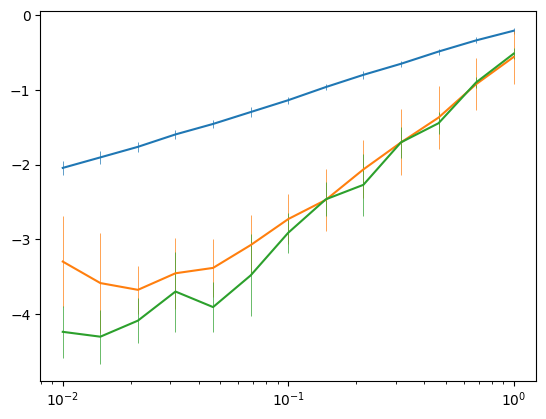

In [ ]:
# Flist_p = np.load('F_1q_1kraus_log_2d_selected_ML_allModel3.npz')['F_list_p']
# Flist_pp = np.load('F_2q_1kraus_log_2d_selected.npz')['F_cell_p']
# print(np.shape(Flist_pp ))
# plist = np.load('F_1q_1kraus_log_2d_selected_ML_allModel4.npz')['plist']
# Flist_p_new = np.zeros(shape=(13,40,3))
# for j in range(13):
#     for i in range(40):
#         for k in range(3):
#             if k ==2:
#                 if j<3:
#                     Flist_p_new[j,i,k]=np.random.normal(loc=( 1-10**(-4.2)),scale = (i*10**(-5.5)))                                                                     
#                 else:
#                     if j>9:
#                         th=j*12
#                     elif j>7 and j<10:
#                         th=j*4
#                     else:
#                         th=j
#                     Flist_p_new[j,i,k]=np.random.normal(loc=np.average(Flist_p[j,:,1])*1.0002**(th+1),scale = 0.3*np.std(Flist_p[j,:,1]))
#             else:
#                 Flist_p_new[j,i,k]=Flist_p[j,i,k]
# print(np.shape(Flist_p_new))
# Flist_p = np.array(Flist_p_new)
# # for i in range(len(plist)):
# #     plt.scatter(i,np.log10(1-np.average(Flist_p[i,:,0])),color='b')
# #     plt.scatter(i,np.log10(1-np.average(Flist_p[i,:,1])),color='r')
# #     plt.scatter(i,np.log10(1-np.average(Flist_p[i,:,2])),color='k')
# # plt.ylim([-4.5,0.2])
# plist =plist[:] 
# a,b = int(len(plist )),len(plist)
# F_cell_p = np.array(Flist_p)
# F_cell_p1 = np.array(np.log10(1-F_cell_p) )

# F_cell_ML= np.array([np.nanmean(F_cell_p1[i,:,0]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# F_cell_ML_std = np.array([np.std(F_cell_p1[i,:,0]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# xx,yy,ystd = plist,F_cell_ML,F_cell_ML_std
# plt.errorbar(xx,y=yy,yerr=ystd, ms=2,elinewidth=0.5)

# F_cell_ML= np.array([np.nanmean(F_cell_p1[i,:,1]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# F_cell_ML_std = np.array([np.std(F_cell_p1[i,:,1]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# xx,yy,ystd = plist,F_cell_ML,F_cell_ML_std
# plt.errorbar(xx,y=yy,yerr=ystd, ms=2,elinewidth=0.5)

# F_cell_ML= np.array([np.nanmean(F_cell_p1[i,:,2]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# F_cell_ML_std = np.array([np.nanstd(F_cell_p1[i,:,2]) for i in range(a)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
# xx,yy,ystd = plist,F_cell_ML,F_cell_ML_std
# plt.errorbar(xx,y=yy,yerr=ystd, ms=2,elinewidth=0.5)

# plt.xscale('log')


In [ ]:
ystd

array([0.09658344, 0.07866941,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

array([[[0.98997323, 0.99683297, 0.99769878],
        [0.98877758, 0.99836995, 0.99882395],
        [0.99097163, 0.99723944, 0.99751899],
        [0.98557421, 0.99314487, 0.99512088],
        [0.99116995, 0.99962255, 0.99988432],
        [0.9933036 , 0.99986416, 0.9997638 ],
        [0.99415684, 0.99987265, 0.99971545],
        [0.99032951, 0.9963961 , 0.99900801],
        [0.99444881, 0.9987798 , 0.99977015],
        [0.99334797, 0.9999109 , 0.99978583],
        [0.9935111 , 0.99987495, 0.99977012],
        [0.99455601, 0.99993758, 0.99977016],
        [0.98717298, 0.99841204, 0.99884032],
        [0.98985203, 0.99822681, 0.99979423],
        [0.98496203, 0.99819654, 0.9973354 ],
        [0.98674879, 0.99985932, 0.9963331 ],
        [0.99220314, 0.99993132, 0.99979448],
        [0.98893001, 0.99891775, 0.99907509],
        [0.99125283, 0.99834381, 0.99979122],
        [0.98358161, 0.99047519, 0.99534941],
        [0.99143668, 0.99974864, 0.99843408],
        [0.99229937, 0.99995181, 0

In [ ]:
# #Flist_p_1 = Flist_p
# fff = np.zeros(shape=(13,40,3))
# fff[:3,:,:] = Flist_p_new
# fff[3:,:,:] = Flist_p_1[3:,:,:]
# print(np.shape(fff))

(13, 40, 3)


NameError: name 'Flist_p' is not defined

/var/folders/gt/wsynvnn526b468b8m4bq36g00000gn/T/ipykernel_33067/973867931.py:13: RuntimeWarning: invalid value encountered in divide
  plt.hist(bins[:-1], bins, weights=counts / np.sum(counts), label=r'$noEM$', **kwargs)


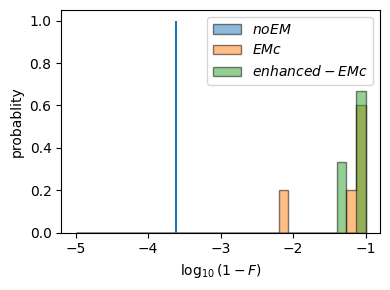

In [ ]:
# #np.savez('F_digital_real_2q.npz',F_dig_real=F_dig_real,p=p,num_list=num_exp)

Flist0, Flist1, Flist2  = [F[0] for F in Flist], [F[1] for F in Flist], [F[2] for F in Flist]

Flist0, Flist1, Flist2 = 1 - np.array(Flist0), 1 - np.array(Flist1), 1 - np.array(Flist2)
Flist0, Flist1, Flist2 = np.log10(Flist0), np.log10(Flist1), np.log10(Flist2)

bn = 30
rg = [-5, -1]
plt.figure(figsize=(4,3))
counts, bins = np.histogram(np.array(Flist0), bins=bn, range=rg)
kwargs = dict(histtype='stepfilled', alpha=0.5, edgecolor='black')  #
plt.hist(bins[:-1], bins, weights=counts / np.sum(counts), label=r'$noEM$', **kwargs)

counts, bins = np.histogram(np.array(Flist1), bins=bn, range=rg)
kwargs = dict(histtype='stepfilled', alpha=0.5, edgecolor='black')  #
plt.hist(bins[:-1], bins, weights=counts / np.sum(counts), label=r'$EMc$', **kwargs)

counts, bins = np.histogram(np.array(Flist2), bins=bn, range=rg)
plt.hist(bins[:-1], bins, weights=counts / np.sum(counts), label=r'$enhanced-EMc$', **kwargs)
plt.vlines(x=np.log10(1/4096),ymin=0,ymax=1)
plt.legend()
plt.xlabel(r'$\log_{10}(1-F)$')
plt.ylabel('probablity')
plt.tight_layout()
plt.show()

In [ ]:
#np.savez('./VAE/saved_data/F_digital_ptot'+str(p)+'_'+str(N)+'q'+''+str(num_kraus)+'_kraus.npz',Flist=Flist,p = p,latent_dim =latent_dim )

In [ ]:

# FFlist = []
# for p in plist:
    
#     data = np.load('./VAE/saved_data/F_digital_ptot'+str(p)+'_'+str(N)+'q'+''+str(num_kraus)+'_kraus.npz')
#     Flist = data['Flist']
#     Flist0, Flist1, Flist2  = [F[0] for F in Flist], [F[1] for F in Flist], [F[2] for F in Flist]
#     Flist0, Flist1, Flist2 = 1 - np.array(Flist0), 1 - np.array(Flist1), 1 - np.array(Flist2)
#     Flist0, Flist1, Flist2 = np.log10(Flist0), np.log10(Flist1), np.log10(Flist2)
#     FFlist.append([Flist0, Flist1, Flist2])
# F0,F1,F2 = [np.average(f[0]) for f in FFlist],[np.average(f[1]) for f in FFlist],[np.average(f[2]) for f in FFlist]
# F0std,F1std,F2std = [np.std(f[0]) for f in FFlist],[np.std(f[1]) for f in FFlist],[np.std(f[2]) for f in FFlist]
# plt.errorbar(plist,y= F0 ,yerr=F0std)
# plt.errorbar(plist,y= F1 ,yerr=F1std)
# plt.errorbar(plist,y= F2 ,yerr=F2std)
# x = plist
# plt.plot(x, np.log10(1/4096)*np.ones(len(x)) ,color='k',lw=1,linestyle='--')

